<a href="https://colab.research.google.com/github/majaszymajda/przetwarzanie_strumieni_danych/blob/main/rowery_projekt_MiNBD.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import numpy.random as rnd
from datetime import datetime
from scipy import stats
from sklearn.decomposition import PCA
from sklearn.discriminant_analysis import LinearDiscriminantAnalysis          
from sklearn.neighbors import KNeighborsClassifier 
from sklearn.model_selection import train_test_split
import seaborn as sns

import warnings
warnings.filterwarnings('ignore')
from sklearn.pipeline import make_pipeline
from sklearn.preprocessing import StandardScaler
from sklearn.svm import SVC, SVR
from sklearn.tree import DecisionTreeClassifier
from sklearn.neural_network import MLPClassifier
from sklearn.linear_model import LinearRegression
from sklearn.ensemble import VotingClassifier
from sklearn.metrics import precision_score, classification_report, roc_auc_score
from sklearn import datasets, metrics, model_selection, svm
import seaborn as sns
sns.set_style('whitegrid')
%matplotlib inline

plt.rcParams['figure.figsize'] = [12, 8]

#Opis danych 
* "data" - data pomiaru
* "time" - czas pomiaru, wykonywane są co godzinę
* "cnt" - liczba nowych osób wypożczających rowery
* "t1" - temperatura 
* "t2" - temperatura odczuwalna
* "hum" - wilgotność powietrza
* "windspeed" - prędkość wiatru w km/h 
* "weathercode" - kategoria pogody (opis poniżej )
* "isholiday" - zmienna binarna - mówi o tym czy mamy okres wakacji czy nie 1 oznacza wakacje, 0 okres nie wakacyjny
* "isweekend" - zmienna binarna - mówi o tym czy mamy weekend, 1 oznacza dni weekendowe, 0 pozostałe dni tyg
* "season" - oznacza pory toku: 0-wiosna ; 1-lato; 2-jesień; 3-zima.

###Kategorie pogody: 
* 1 = Clear ; mostly clear but have some values with haze/fog/patches of fog/ fog in vicinity 
* 2 = scattered clouds / few clouds 
* 3 = Broken clouds 
* 4 = Cloudy 
* 7 = Rain/ light Rain shower/ Light rain 
* 10 = rain with thunderstorm 
* 26 = snowfall 
* 94 = Freezing Fog

In [ ]:
filename = 'dane_rowery.csv'
df = pd.read_csv(filename)   
print(df)

                timestamp   cnt   t1  ...  is_holiday  is_weekend  season
0     2016-01-01 00:00:00   786  6.0  ...         1.0         0.0     3.0
1     2016-01-01 01:00:00   660  5.5  ...         1.0         0.0     3.0
2     2016-01-01 02:00:00   387  5.0  ...         1.0         0.0     3.0
3     2016-01-01 03:00:00   294  5.0  ...         1.0         0.0     3.0
4     2016-01-01 04:00:00   219  5.0  ...         1.0         0.0     3.0
...                   ...   ...  ...  ...         ...         ...     ...
8766  2017-01-03 19:00:00  1042  5.0  ...         0.0         0.0     3.0
8767  2017-01-03 20:00:00   541  5.0  ...         0.0         0.0     3.0
8768  2017-01-03 21:00:00   337  5.5  ...         0.0         0.0     3.0
8769  2017-01-03 22:00:00   224  5.5  ...         0.0         0.0     3.0
8770  2017-01-03 23:00:00   139  5.0  ...         0.0         0.0     3.0

[8771 rows x 10 columns]


In [ ]:
df.head()

,timestamp,cnt,t1,t2,hum,wind_speed,weather_code,is_holiday,is_weekend,season
0,2016-01-01 00:00:00,786,6.0,3.5,81.0,13.0,1.0,1.0,0.0,3.0
1,2016-01-01 01:00:00,660,5.5,3.0,84.0,11.0,1.0,1.0,0.0,3.0
2,2016-01-01 02:00:00,387,5.0,2.5,84.0,10.0,1.0,1.0,0.0,3.0
3,2016-01-01 03:00:00,294,5.0,4.5,81.0,5.0,1.0,1.0,0.0,3.0
4,2016-01-01 04:00:00,219,5.0,4.0,76.0,5.5,1.0,1.0,0.0,3.0


Szczegółowe dane statystyczne dotyczące danej 'ctn' - liczby wypożyczonych rowerów w danej godzinie

In [ ]:
df.describe()

,cnt,t1,t2,hum,wind_speed,weather_code,is_holiday,is_weekend,season
count,8771.000000,8771.000000,8771.000000,8771.000000,8771.000000,8771.000000,8771.000000,8771.000000,8771.000000
mean,1159.186638,12.318417,11.302284,73.272489,15.168130,2.696500,0.024627,0.286398,1.507240
std,1105.373438,5.907147,6.942326,14.217901,7.663815,2.292173,0.154993,0.452104,1.123619
min,9.000000,-1.000000,-5.000000,23.000000,0.000000,1.000000,0.000000,0.000000,0.000000
25%,248.000000,8.000000,5.000000,64.000000,9.000000,1.000000,0.000000,0.000000,1.000000
50%,856.000000,12.000000,12.000000,76.000000,14.000000,2.000000,0.000000,0.000000,2.000000
75%,1704.000000,16.500000,16.500000,84.000000,19.500000,3.000000,0.000000,1.000000,3.000000
max,5422.000000,33.000000,32.500000,100.000000,56.000000,26.000000,1.000000,1.000000,3.000000


Dodanie dodatkowej tabeli przechowaujacej id danego pomiaru

In [ ]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 8771 entries, 0 to 8770
Data columns (total 10 columns):
 #   Column        Non-Null Count  Dtype  
---  ------        --------------  -----  
 0   timestamp     8771 non-null   object 
 1   cnt           8771 non-null   int64  
 2   t1            8771 non-null   float64
 3   t2            8771 non-null   float64
 4   hum           8771 non-null   float64
 5   wind_speed    8771 non-null   float64
 6   weather_code  8771 non-null   float64
 7   is_holiday    8771 non-null   float64
 8   is_weekend    8771 non-null   float64
 9   season        8771 non-null   float64
dtypes: float64(8), int64(1), object(1)
memory usage: 685.4+ KB


In [ ]:
df["Id"] = df.index + 1

In [ ]:
df['timestamp'] = df['timestamp'] .apply(lambda x :datetime.strptime(x,'%Y-%m-%d %H:%M:%S'))
df['month'] = df['timestamp'].apply(lambda x : str(x).split(' ')[0].split('-')[1])
df['day'] = df['timestamp'].apply(lambda x : str(x).split(' ')[0].split('-')[2])
df['hour'] = df['timestamp'].apply(lambda x : str(x).split(' ')[1].split(':')[0])

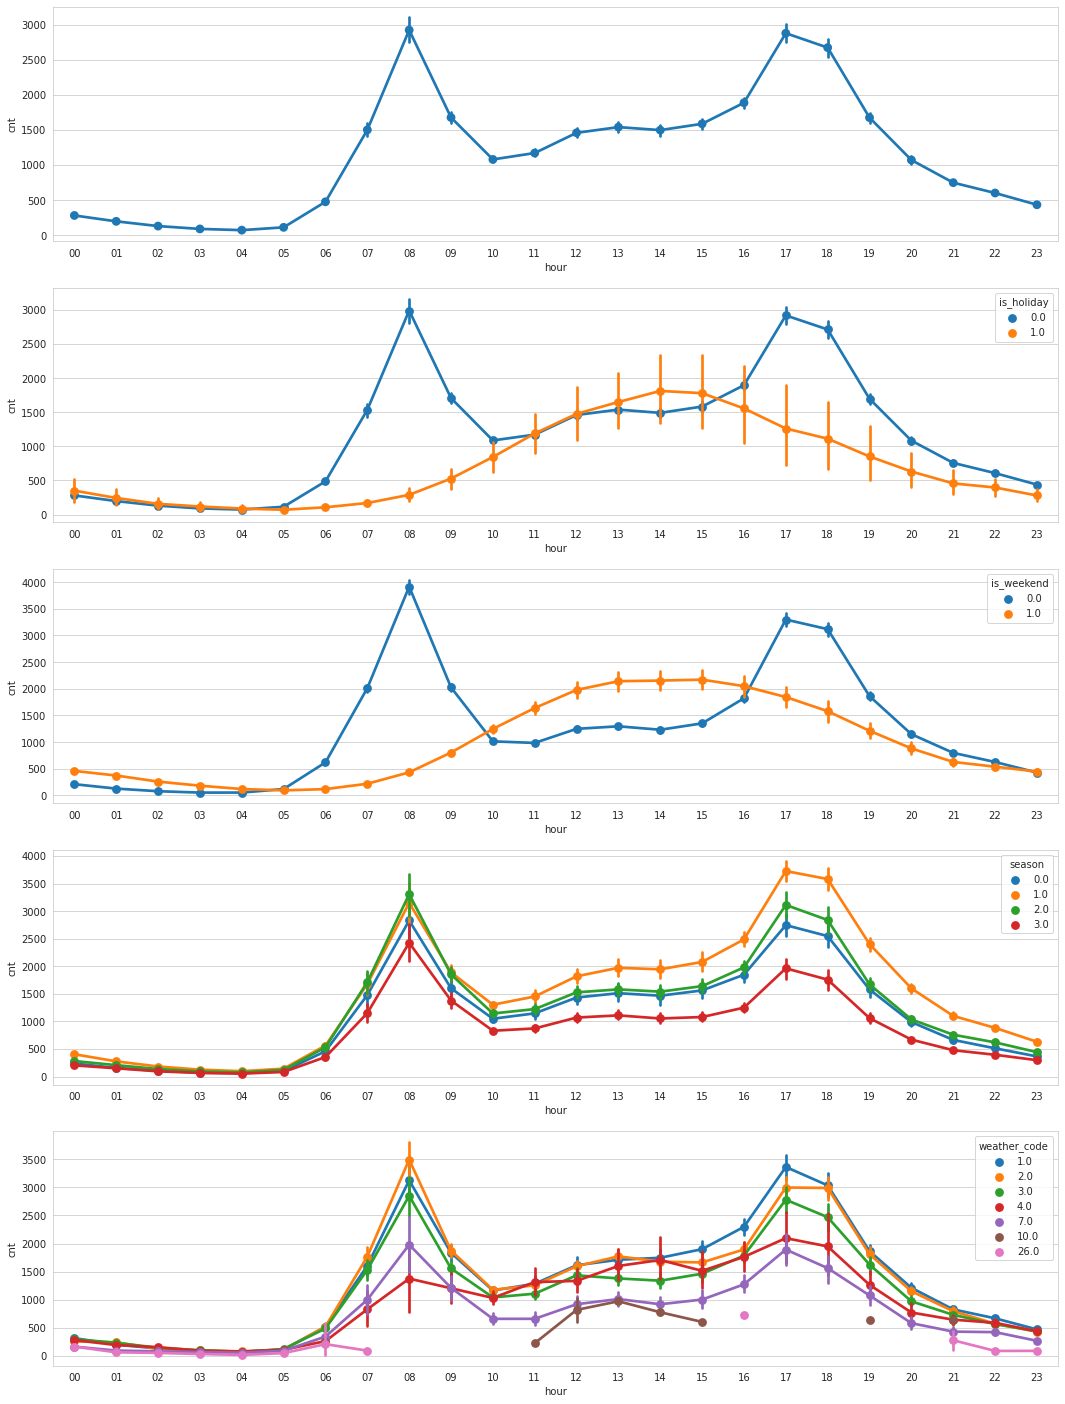

In [ ]:
fig,(ax1, ax2, ax3, ax4, ax5)= plt.subplots(nrows=5)
fig.set_size_inches(18,25)

sns.pointplot(data=df, x='hour', y='cnt', ax=ax1)
sns.pointplot(data=df, x='hour', y='cnt', hue='is_holiday', ax=ax2)
sns.pointplot(data=df, x='hour', y='cnt', hue='is_weekend', ax=ax3)
sns.pointplot(data=df, x='hour', y='cnt', hue='season', ax=ax4)
sns.pointplot(data=df, x='hour', y='cnt', hue='weather_code',ax=ax5)

In [ ]:
xdf = df.copy()

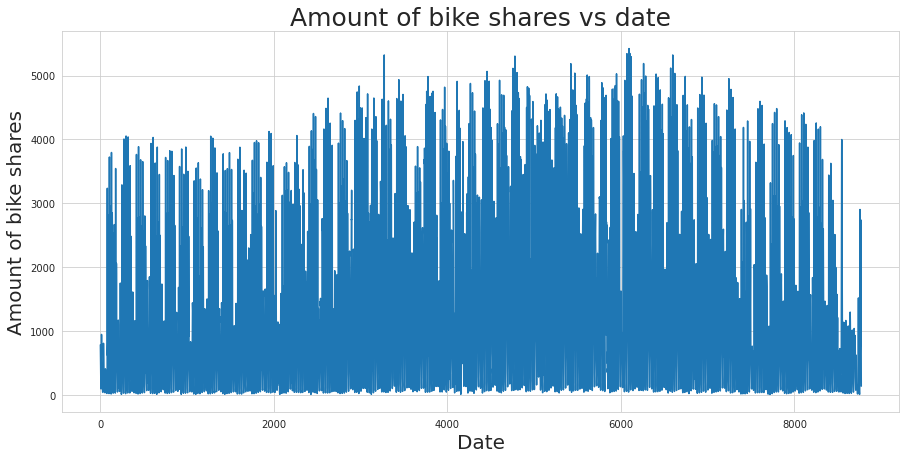

In [ ]:
plt.figure(figsize=(15, 7))
ax = sns.lineplot(x=xdf.index, y=xdf.cnt,data=xdf)
ax.set_title("Amount of bike shares vs date", fontsize=25)
ax.set_xlabel("Date", fontsize=20)
ax.set_ylabel('Amount of bike shares', fontsize=20)
plt.show()

Wykres repeztujacy ilość pomiarów danej wielkości 'cnt'

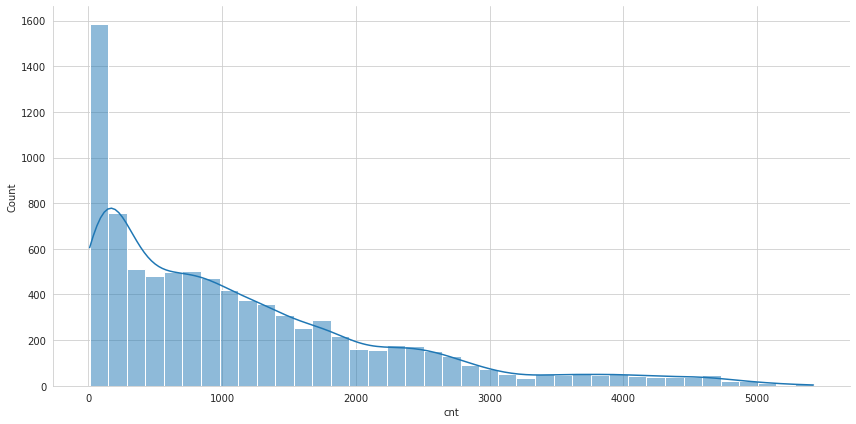

In [ ]:
sns.displot(x = 'cnt', data = xdf, aspect = 2, height = 6, kde = True);

Poniżek wykres punktowy reperzentujący wartości nowych użytkowników, jak widać istnieje pewna liczba wartości odstających.

In [ ]:
# plt.figure(figsize = (8,6))
# sns.scatterplot(x = 'cnt', y = "Id", data = xdf);

Poniżej wykres pudełkowy potwierdza wniosek wyciągnięty z wykresu punktowego, mamy pewną liczbą watości odstających.

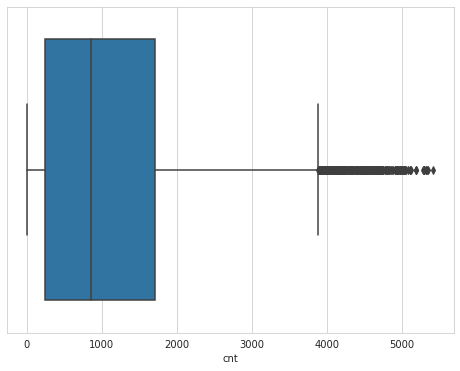

In [ ]:
plt.figure(figsize = (8,6))
sns.boxplot(x = "cnt", data = xdf);

In [ ]:
df['cnt'].describe()

count    8771.000000
mean     1159.186638
std      1105.373438
min         9.000000
25%       248.000000
50%       856.000000
75%      1704.000000
max      5422.000000
Name: cnt, dtype: float64

In [ ]:
def sqrt_transformation(dataframe):
  return np.sqrt(dataframe)


# function for removing outliers

def remove_outliers(dataframe, column):
  q3 = dataframe[column].quantile(0.75)
  q1 = dataframe[column].quantile(0.25)
  IQR = q3 - q1
  
  upper = q3 + (1.5 * IQR)
  lower = q1 - (1.5 * IQR)
  
  dataframe = dataframe[(dataframe[column] > lower ) & (dataframe[column] < upper)]

  return dataframe

In [ ]:
xdf = remove_outliers(xdf,'cnt')

In [ ]:
xdf

,timestamp,cnt,t1,t2,hum,wind_speed,weather_code,is_holiday,is_weekend,season,Id,month,day,hour
0,2016-01-01 00:00:00,786,6.0,3.5,81.0,13.0,1.0,1.0,0.0,3.0,1,01,01,00
1,2016-01-01 01:00:00,660,5.5,3.0,84.0,11.0,1.0,1.0,0.0,3.0,2,01,01,01
2,2016-01-01 02:00:00,387,5.0,2.5,84.0,10.0,1.0,1.0,0.0,3.0,3,01,01,02
3,2016-01-01 03:00:00,294,5.0,4.5,81.0,5.0,1.0,1.0,0.0,3.0,4,01,01,03
4,2016-01-01 04:00:00,219,5.0,4.0,76.0,5.5,1.0,1.0,0.0,3.0,5,01,01,04
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
8766,2017-01-03 19:00:00,1042,5.0,1.0,81.0,19.0,3.0,0.0,0.0,3.0,8767,01,03,19
8767,2017-01-03 20:00:00,541,5.0,1.0,81.0,21.0,4.0,0.0,0.0,3.0,8768,01,03,20
8768,2017-01-03 21:00:00,337,5.5,1.5,78.5,24.0,4.0,0.0,0.0,3.0,8769,01,03,21
8769,2017-01-03 22:00:00,224,5.5,1.5,76.0,23.0,4.0,0.0,0.0,3.0,8770,01,03,22


Analiza pozoztałych danych na wykresach dwu wymiarowych:

In [ ]:
xdf.columns

Index(['timestamp', 'cnt', 't1', 't2', 'hum', 'wind_speed', 'weather_code',
       'is_holiday', 'is_weekend', 'season', 'Id', 'month', 'day', 'hour'],
      dtype='object')

In [ ]:
numerical_df = xdf.select_dtypes(exclude='object')
print(numerical_df)

               timestamp   cnt   t1   t2  ...  is_holiday  is_weekend  season    Id
0    2016-01-01 00:00:00   786  6.0  3.5  ...         1.0         0.0     3.0     1
1    2016-01-01 01:00:00   660  5.5  3.0  ...         1.0         0.0     3.0     2
2    2016-01-01 02:00:00   387  5.0  2.5  ...         1.0         0.0     3.0     3
3    2016-01-01 03:00:00   294  5.0  4.5  ...         1.0         0.0     3.0     4
4    2016-01-01 04:00:00   219  5.0  4.0  ...         1.0         0.0     3.0     5
...                  ...   ...  ...  ...  ...         ...         ...     ...   ...
8766 2017-01-03 19:00:00  1042  5.0  1.0  ...         0.0         0.0     3.0  8767
8767 2017-01-03 20:00:00   541  5.0  1.0  ...         0.0         0.0     3.0  8768
8768 2017-01-03 21:00:00   337  5.5  1.5  ...         0.0         0.0     3.0  8769
8769 2017-01-03 22:00:00   224  5.5  1.5  ...         0.0         0.0     3.0  8770
8770 2017-01-03 23:00:00   139  5.0  1.0  ...         0.0         0.0     3.

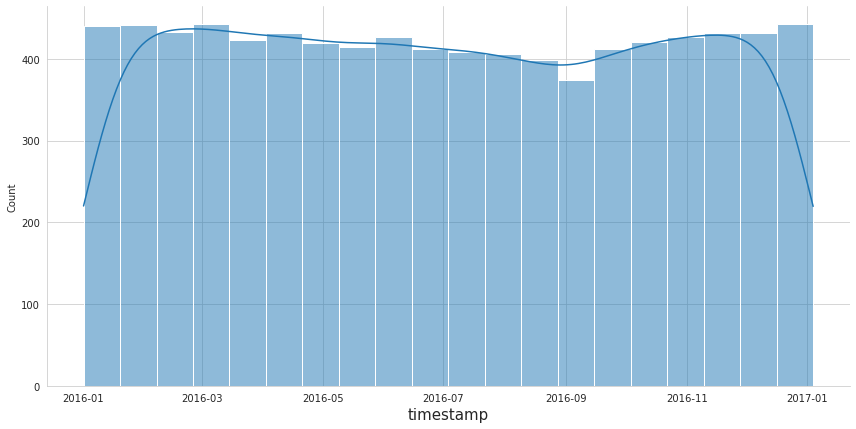

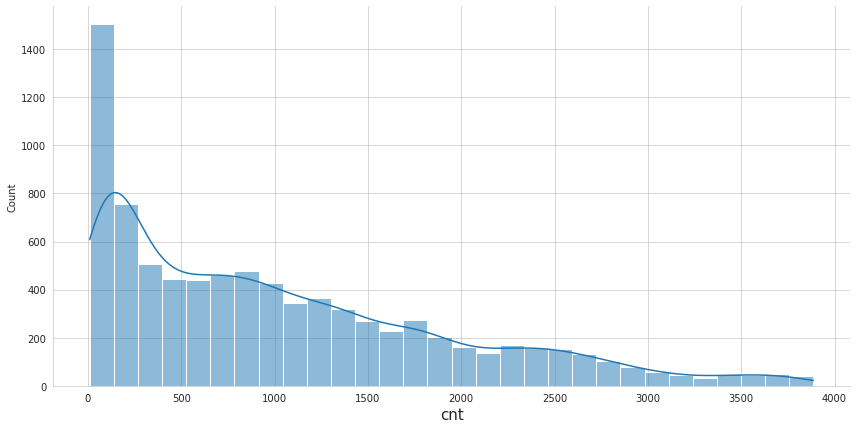

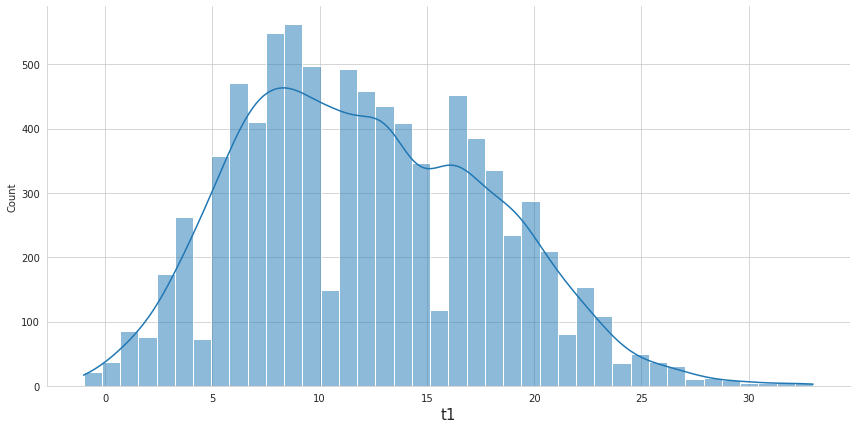

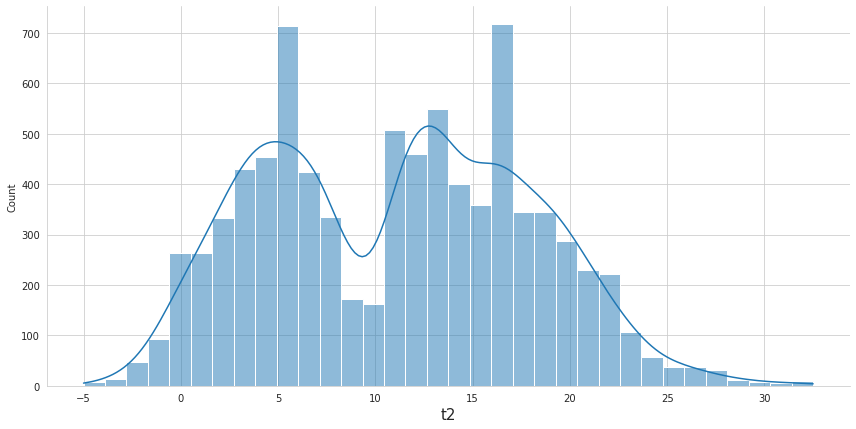

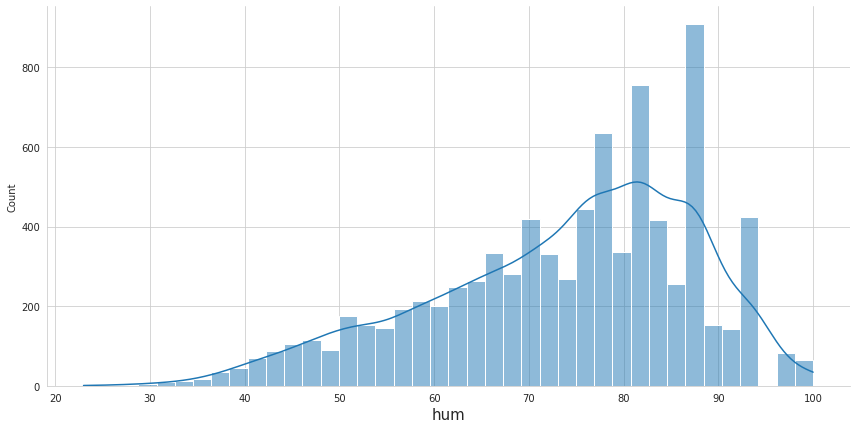

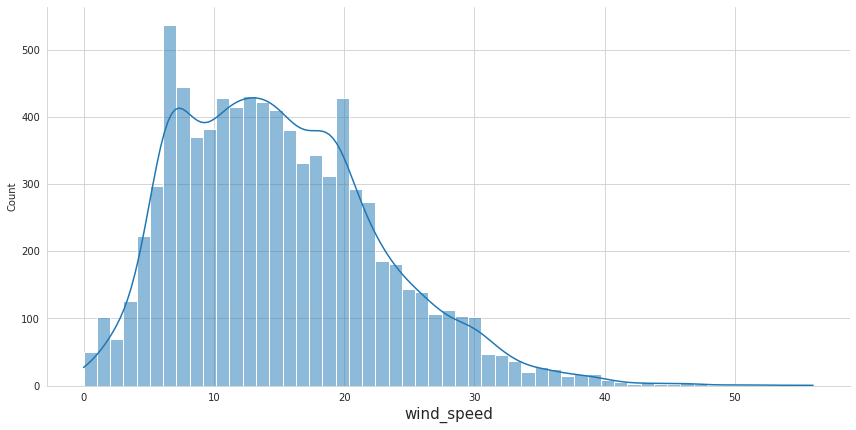

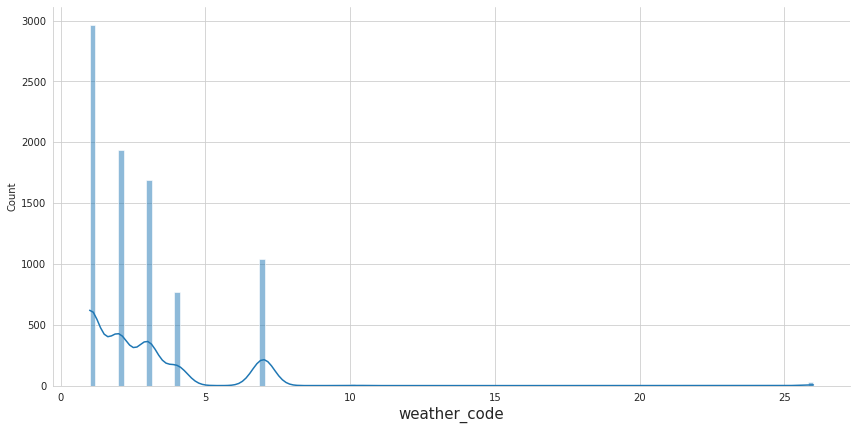

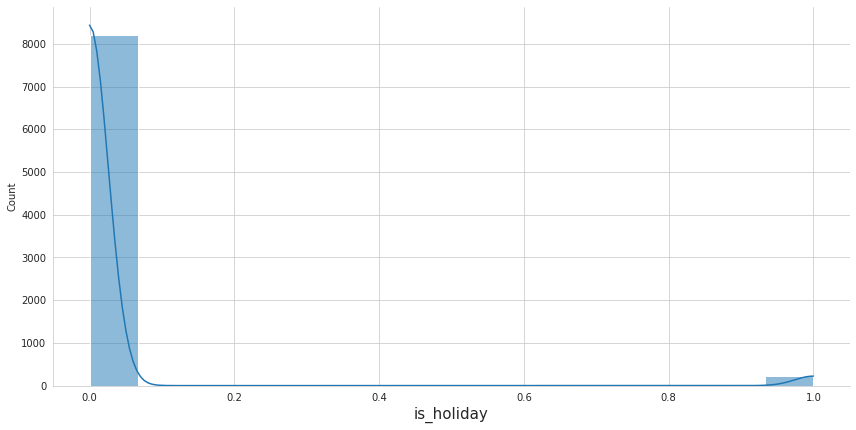

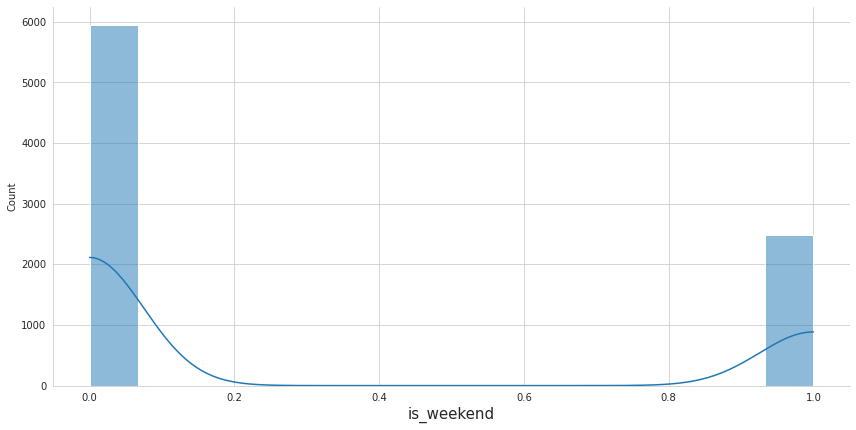

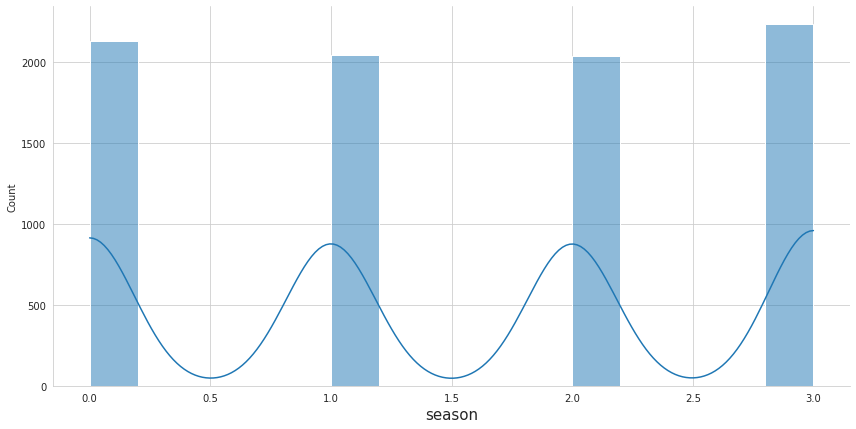

In [ ]:
for i in numerical_df:
  if i == "data" or i == 'Id':
    continue
  else:
    sns.displot(x = i, data = xdf, height = 6, aspect = 2, kde = True);
    plt.xlabel(i, fontsize = 15)


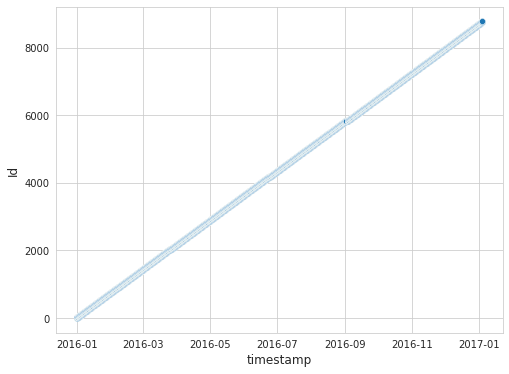

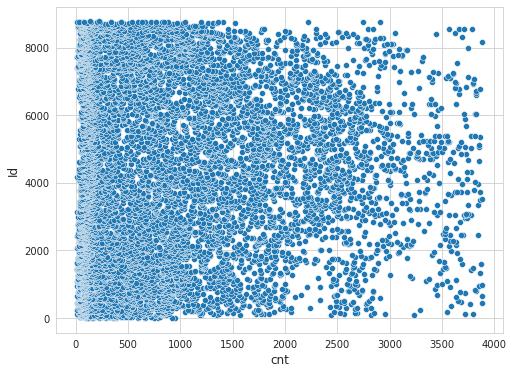

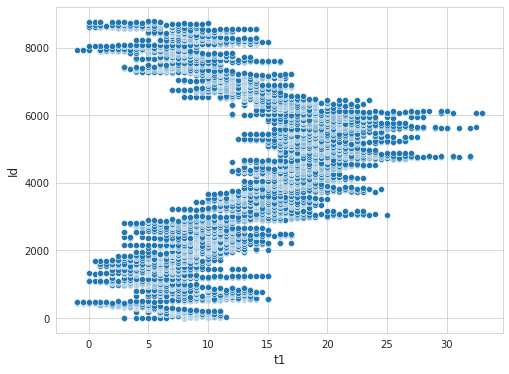

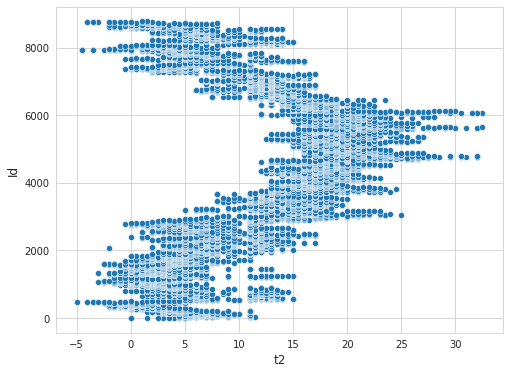

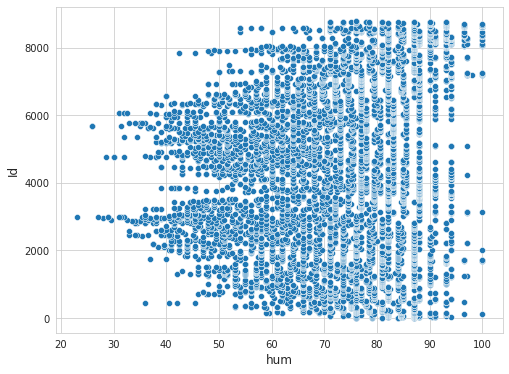

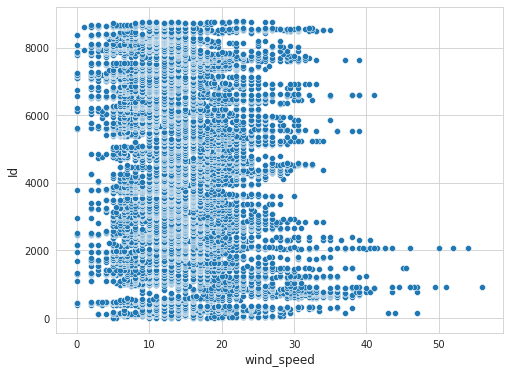

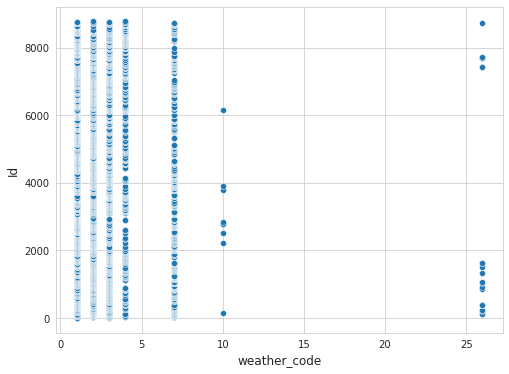

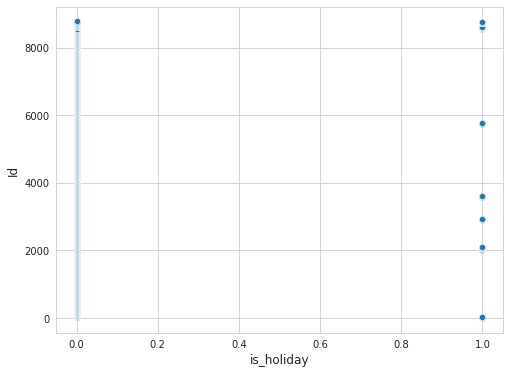

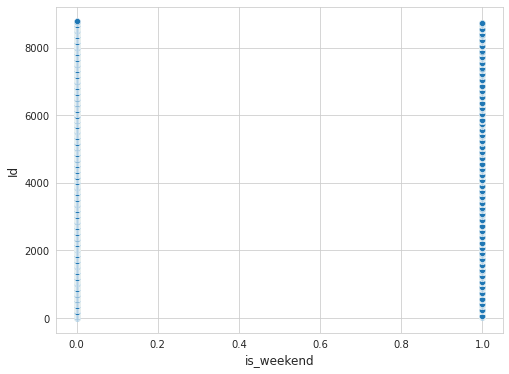

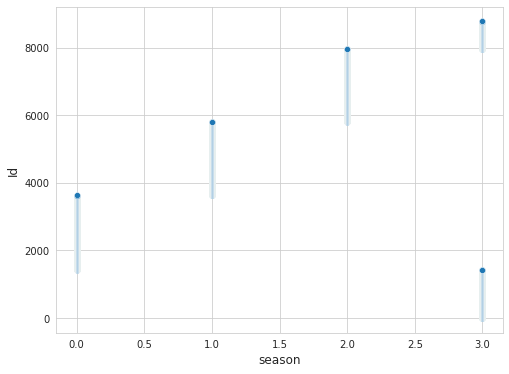

In [ ]:
for i in numerical_df:
  if i == "data" or i == 'Id':
    continue
  else:
    plt.figure(figsize = (8,6))
    sns.scatterplot(x = i, y = "Id", data = xdf);
    plt.xlabel(i, fontsize = 12)
    plt.ylabel("Id", fontsize = 12)

## Obserwacje na podstawie wykresów:
t1 , t2 has some outliers
hum is negatively skewed and has outliers below q1
wind_speed has also some outliers.
whereas, weather_code is actually a categorical variable, we won't be fixing it

# Kategorie pogodowe

In [ ]:
xdf['weather_code'].value_counts()

1.0     2963
2.0     1937
3.0     1688
7.0     1043
4.0      767
26.0      27
10.0      10
Name: weather_code, dtype: int64

In [ ]:
categorical_df = ['weather_code']

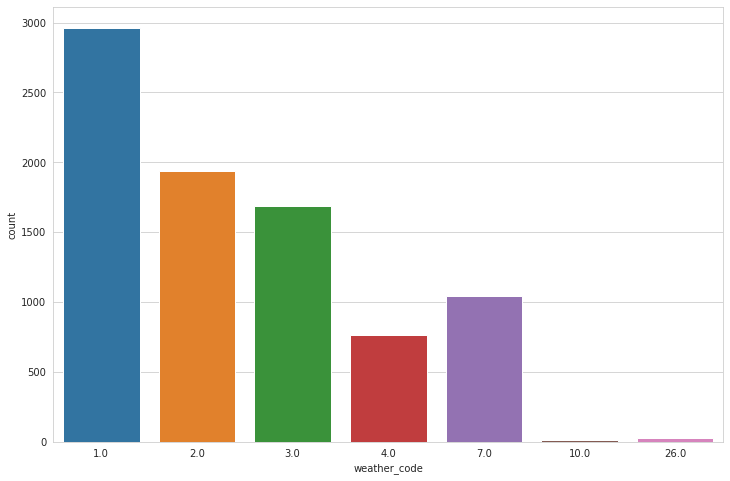

In [ ]:
for i in categorical_df:
  sns.countplot(x = i, data = xdf);

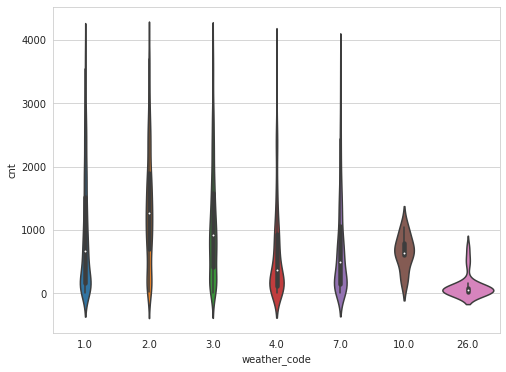

In [ ]:
plt.figure(figsize = (8,6))
sns.violinplot(y = 'cnt', x = 'weather_code', data = xdf);

In [ ]:
xdf['timestamp'] = pd.to_datetime(df['timestamp'], format = '%Y%m%d %H:%M:%S')

xdf['year'] = xdf['timestamp'].dt.year
xdf['month'] = xdf['timestamp'].dt.month
xdf['hour'] = xdf['timestamp'].dt.hour

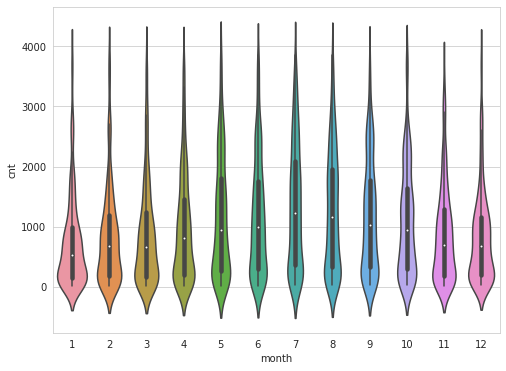

In [ ]:
plt.figure(figsize = (8,6))
sns.violinplot(x = xdf['month'] , y = 'cnt', data = xdf);


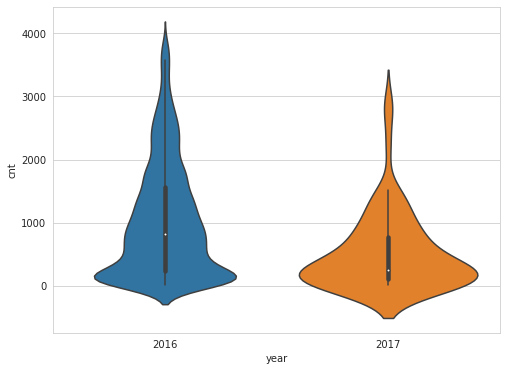

In [ ]:
plt.figure(figsize = (8,6))
sns.violinplot(x = xdf['year'] , y = 'cnt', data = xdf);


# Przygotowanie danych

In [ ]:
xdf.drop(['timestamp','Id'], axis = 1, inplace = True)

In [ ]:
X = xdf.drop('season', axis = 1)
Y = xdf['season']

In [ ]:
from sklearn.preprocessing import StandardScaler

scaler = StandardScaler()

X1 = scaler.fit_transform(X)
X = pd.DataFrame(data = X1, columns = X.columns)

X_b_PCA = xdf

In [ ]:
pca = PCA(n_components=3)
X = pca.fit_transform(X_b_PCA)
print(pca.explained_variance_ratio_)  
print()
print(pca.singular_values_)  
                            
print(X_b_PCA.shape)
print(X.shape)
print(X)

[9.99494907e-01 1.98008660e-04 9.59929301e-05]

[83360.98561304  1173.31504614   816.94378296]
(8435, 13)
(8435, 3)
[[-2.43283630e+02  9.13278293e+00  1.48655654e+01]
 [-3.69303223e+02  1.13693255e+01  1.45386779e+01]
 [-6.42293167e+02  9.35665534e+00  1.45242672e+01]
 ...
 [-6.92178897e+02 -2.89589312e-01  1.59638234e+01]
 [-8.05153908e+02 -3.47384041e+00  1.59466566e+01]
 [-8.90150655e+02 -3.96956095e+00  1.58992765e+01]]


In [ ]:
X_train, X_test, Y_train, Y_test = train_test_split(X, Y)

X_train.shape, X_test.shape, Y_train.shape, Y_test.shape

((6326, 3), (2109, 3), (6326,), (2109,))

In [ ]:
clf1 = KNeighborsClassifier(n_neighbors=5)
clf1.fit(X_train, Y_train)
      
predictArr = list(clf1.predict(X_test))

precScore = precision_score(Y_test, predictArr, average='macro')

classReport = classification_report(Y_test, predictArr)

print(precScore)
print(classReport)

0.3302932088328289
              precision    recall  f1-score   support

         0.0       0.29      0.34      0.32       530
         1.0       0.32      0.38      0.35       484
         2.0       0.29      0.27      0.28       524
         3.0       0.41      0.32      0.36       571

    accuracy                           0.33      2109
   macro avg       0.33      0.33      0.33      2109
weighted avg       0.33      0.33      0.33      2109



In [ ]:
clf2 = make_pipeline(StandardScaler(), SVC(gamma='auto', probability=True))
clf2.fit(X_train, Y_train)
predictArr = list(clf2.predict(X_test))
precScore = precision_score(Y_test, predictArr, average='macro')

classReport = classification_report(Y_test, predictArr)

print(precScore)
print(classReport)

0.41243634859970224
              precision    recall  f1-score   support

         0.0       0.41      0.19      0.26       530
         1.0       0.46      0.42      0.44       484
         2.0       0.39      0.28      0.32       524
         3.0       0.39      0.72      0.51       571

    accuracy                           0.41      2109
   macro avg       0.41      0.40      0.38      2109
weighted avg       0.41      0.41      0.38      2109



In [ ]:
clf3 = DecisionTreeClassifier()
clf3.fit(X_train, Y_train)

predictArr = list(clf3.predict(X_test))
precScore = precision_score(Y_test, predictArr, average='macro')

classReport = classification_report(Y_test, predictArr)
print(precScore)
print(classReport)

0.3990304865141722
              precision    recall  f1-score   support

         0.0       0.34      0.35      0.35       530
         1.0       0.40      0.40      0.40       484
         2.0       0.39      0.37      0.38       524
         3.0       0.46      0.47      0.46       571

    accuracy                           0.40      2109
   macro avg       0.40      0.40      0.40      2109
weighted avg       0.40      0.40      0.40      2109



In [ ]:
clf4 = MLPClassifier(solver='lbfgs', alpha=1e-5, hidden_layer_sizes=(5, 2), random_state=1)
clf4.fit(X_train, Y_train)

predictArr = list(clf4.predict(X_test))

precScore = precision_score(Y_test, predictArr, average='macro')

classReport = classification_report(Y_test, predictArr)
print(precScore)
print(classReport)


0.10951146445443025
              precision    recall  f1-score   support

         0.0       0.26      0.65      0.37       530
         1.0       0.00      0.00      0.00       484
         2.0       0.00      0.00      0.00       524
         3.0       0.18      0.25      0.21       571

    accuracy                           0.23      2109
   macro avg       0.11      0.22      0.14      2109
weighted avg       0.11      0.23      0.15      2109



In [ ]:
eclf = VotingClassifier(estimators=[('knn', clf1), ('svc', clf2), ('dt', clf3), ('nrn', clf3)], voting='hard')
eclf = eclf.fit(X_train, Y_train)
predictArr = list(eclf.predict(X_test))

precScore = precision_score(Y_test, predictArr, average='macro')

classReport = classification_report(Y_test, predictArr)
print(precScore)
print(classReport)

0.40410237056162995
              precision    recall  f1-score   support

         0.0       0.35      0.38      0.36       530
         1.0       0.41      0.42      0.42       484
         2.0       0.40      0.35      0.37       524
         3.0       0.47      0.46      0.46       571

    accuracy                           0.40      2109
   macro avg       0.40      0.40      0.40      2109
weighted avg       0.41      0.40      0.40      2109



In [ ]:
from sklearn.linear_model import LogisticRegression
clf = LogisticRegression(solver="liblinear").fit(X_train, Y_train)

x = clf.predict_proba(X_test)
y = Y_test

print(x, y)

roc_auc_score(Y_test, clf.predict_proba(X_test), multi_class='ovr')

[[0.3184936  0.22989322 0.20403558 0.2475776 ]
 [0.24179539 0.22413288 0.26655327 0.26751846]
 [0.2141497  0.22725575 0.28802875 0.2705658 ]
 ...
 [0.28663423 0.36418489 0.22712478 0.12205609]
 [0.29680608 0.24421653 0.22349028 0.23548711]
 [0.2545782  0.21032681 0.24937441 0.28572058]] 4570    1.0
699     3.0
7774    2.0
5419    1.0
3774    1.0
       ... 
2362    0.0
3170    0.0
6291    2.0
6159    2.0
3336    0.0
Name: season, Length: 2109, dtype: float64


0.6447266132368219

In [ ]:
from sklearn.datasets import make_blobs
from sklearn.model_selection import train_test_split
import numpy as np
import matplotlib.pyplot as plt
from sklearn import svm
from sklearn.metrics import plot_confusion_matrix

# Konfiguracja
blobs_random_seed = 42
centers = [(0,0), (5,5)]
cluster_std = 1
frac_test_split = 0.33
num_features_for_samples = 2
num_samples_total = 1000



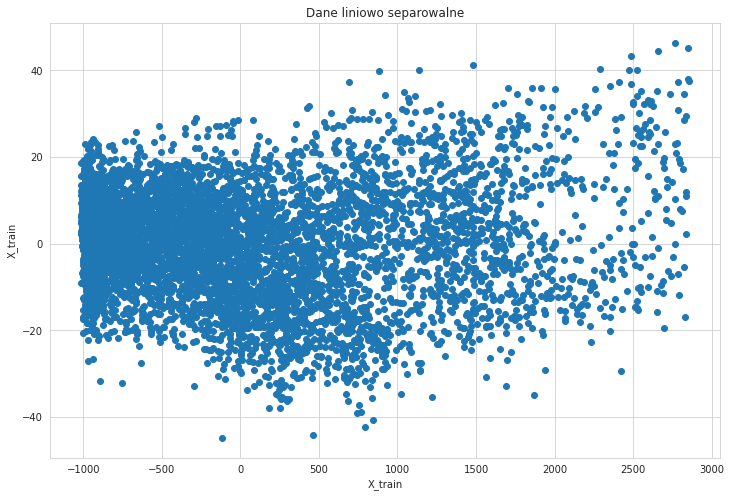

In [ ]:
# Wykres dla ciągu uczącego
plt.scatter(X_train[:,0], X_train[:,1])
plt.title('Dane liniowo separowalne')
plt.xlabel('X_train')
plt.ylabel('X_train')
plt.show()



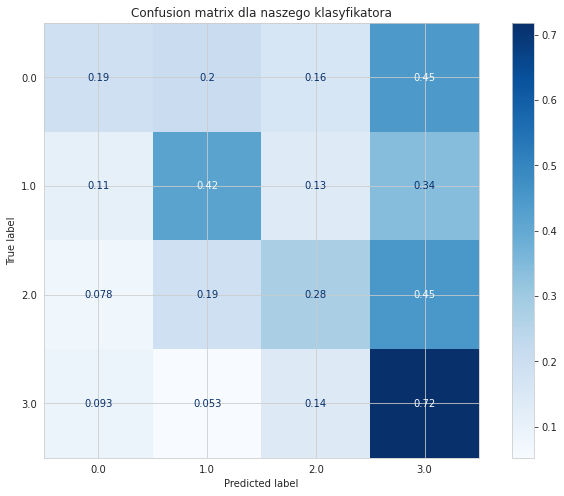

In [ ]:
# Generowanie confusion matrix
matrix = plot_confusion_matrix(clf2, X_test, Y_test, cmap=plt.cm.Blues, normalize='true')
plt.title('Confusion matrix dla naszego klasyfikatora')
plt.show(matrix)
plt.show()



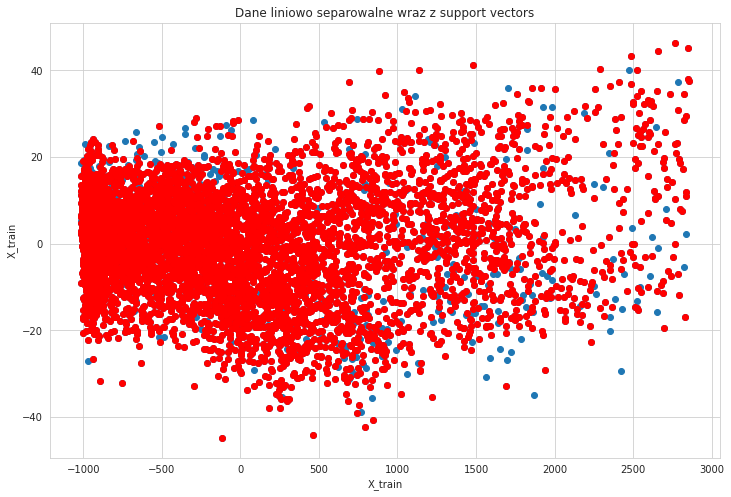

In [ ]:
# Pobranie support vectors
clf = svm.SVC(kernel='linear')
clf = clf.fit(X_train, Y_train)

predictions = clf.predict(X_test)
support_vectors = clf.support_vectors_

# Wyświetlenie support vectors
plt.scatter(X_train[:,0], X_train[:,1])
plt.scatter(support_vectors[:,0], support_vectors[:,1], color='red')
plt.title('Dane liniowo separowalne wraz z support vectors')
plt.xlabel('X_train')
plt.ylabel('X_train')
plt.show()